Credit Scoring Model - Machine Learning Project

IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, 
                             confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

LOAD AND EXPLORE DATA

In [2]:
df = pd.read_csv('Credit_Data.csv')

print("="*80)
print("CREDIT SCORING MODEL - DATA EXPLORATION")
print("="*80)

# Basic information
print("\n1. Dataset Shape:")
print(f"   Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n2. First Few Rows:")
print(df.head())

print("\n3. Dataset Info:")
print(df.info())

print("\n4. Statistical Summary:")
print(df.describe())

print("\n5. Missing Values:")
print(df.isnull().sum())

print("\n6. Target Variable Distribution:")
print(df.iloc[:, -1].value_counts())

CREDIT SCORING MODEL - DATA EXPLORATION

1. Dataset Shape:
   Rows: 1000, Columns: 21

2. First Few Rows:
   default account_check_status  duration_in_month  \
0        0               < 0 DM                  6   
1        1    0 <= ... < 200 DM                 48   
2        0  no checking account                 12   
3        0               < 0 DM                 42   
4        1               < 0 DM                 24   

                                      credit_history  \
0  critical account/ other credits existing (not ...   
1           existing credits paid back duly till now   
2  critical account/ other credits existing (not ...   
3           existing credits paid back duly till now   
4                    delay in paying off in the past   

                        purpose  credit_amount                      savings  \
0           domestic appliances           1169  unknown/ no savings account   
1           domestic appliances           5951                 ... < 100 D

DATA PREPROCESSING

In [3]:
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Handle missing values
print("\n1. Handling Missing Values...")
# Fill numerical columns with median
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("   ✓ Missing values handled")

# Encode categorical variables
print("\n2. Encoding Categorical Variables...")
label_encoders = {}
for col in categorical_cols:
    if col != df.columns[-1]:  # Don't encode target yet
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
print(f"   ✓ Encoded {len(label_encoders)} categorical columns")

# Encode target variable (assuming last column is target)
target_col = df.columns[-1]
if df[target_col].dtype == 'object':
    le_target = LabelEncoder()
    df[target_col] = le_target.fit_transform(df[target_col])
    print(f"   ✓ Target variable '{target_col}' encoded")


DATA PREPROCESSING

1. Handling Missing Values...
   ✓ Missing values handled

2. Encoding Categorical Variables...
   ✓ Encoded 12 categorical columns
   ✓ Target variable 'foreign_worker' encoded


FEATURE ENGINEERING

In [6]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"\n1. Original Features: {X.shape[1]}")

# Create interaction features (example - customize based on your data)
# Example: If you have income and debt columns
feature_names = X.columns.tolist()
if 'income' in [col.lower() for col in feature_names] and 'debt' in [col.lower() for col in feature_names]:
    income_col = [col for col in feature_names if 'income' in col.lower()][0]
    debt_col = [col for col in feature_names if 'debt' in col.lower()][0]
    X['debt_to_income_ratio'] = X[debt_col] / (X[income_col] + 1)
    print("   ✓ Created debt_to_income_ratio feature")

print(f"\n2. Features after Engineering: {X.shape[1]}")


FEATURE ENGINEERING

1. Original Features: 20

2. Features after Engineering: 20


TRAIN-TEST SPLIT AND SCALING

In [7]:
print("\n" + "="*80)
print("DATA SPLITTING AND SCALING")
print("="*80)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set: {X_train.shape[0]} samples")
print(f"Testing Set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\n✓ Features scaled using StandardScaler")


DATA SPLITTING AND SCALING

Training Set: 800 samples
Testing Set: 200 samples

✓ Features scaled using StandardScaler


MODEL TRAINING

In [8]:
print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print('='*60)
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # ROC-AUC (for binary classification)
    if len(np.unique(y)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled), 
                                multi_class='ovr', average='weighted')
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Print metrics
    print(f"\nMetrics for {name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"\n  Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



MODEL TRAINING

Training Logistic Regression...

Metrics for Logistic Regression:
  Accuracy:  0.9650
  Precision: 0.9312
  Recall:    0.9650
  F1-Score:  0.9478
  ROC-AUC:   0.8016

  Cross-Validation Accuracy: 0.9575 (+/- 0.0025)

Training Decision Tree...

Metrics for Decision Tree:
  Accuracy:  0.9500
  Precision: 0.9500
  Recall:    0.9500
  F1-Score:  0.9500
  ROC-AUC:   0.6299

  Cross-Validation Accuracy: 0.9262 (+/- 0.0195)

Training Random Forest...

Metrics for Random Forest:
  Accuracy:  0.9650
  Precision: 0.9312
  Recall:    0.9650
  F1-Score:  0.9478
  ROC-AUC:   0.7702

  Cross-Validation Accuracy: 0.9625 (+/- 0.0000)


MODEL COMPARISON

In [9]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})

print("\n", comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")



MODEL COMPARISON

               Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression     0.965   0.931225   0.965  0.947812 0.801628
      Decision Tree     0.950   0.950000   0.950  0.950000 0.629904
      Random Forest     0.965   0.931225   0.965  0.947812 0.770170

🏆 Best Model: Decision Tree


VISUALIZATIONS


GENERATING VISUALIZATIONS


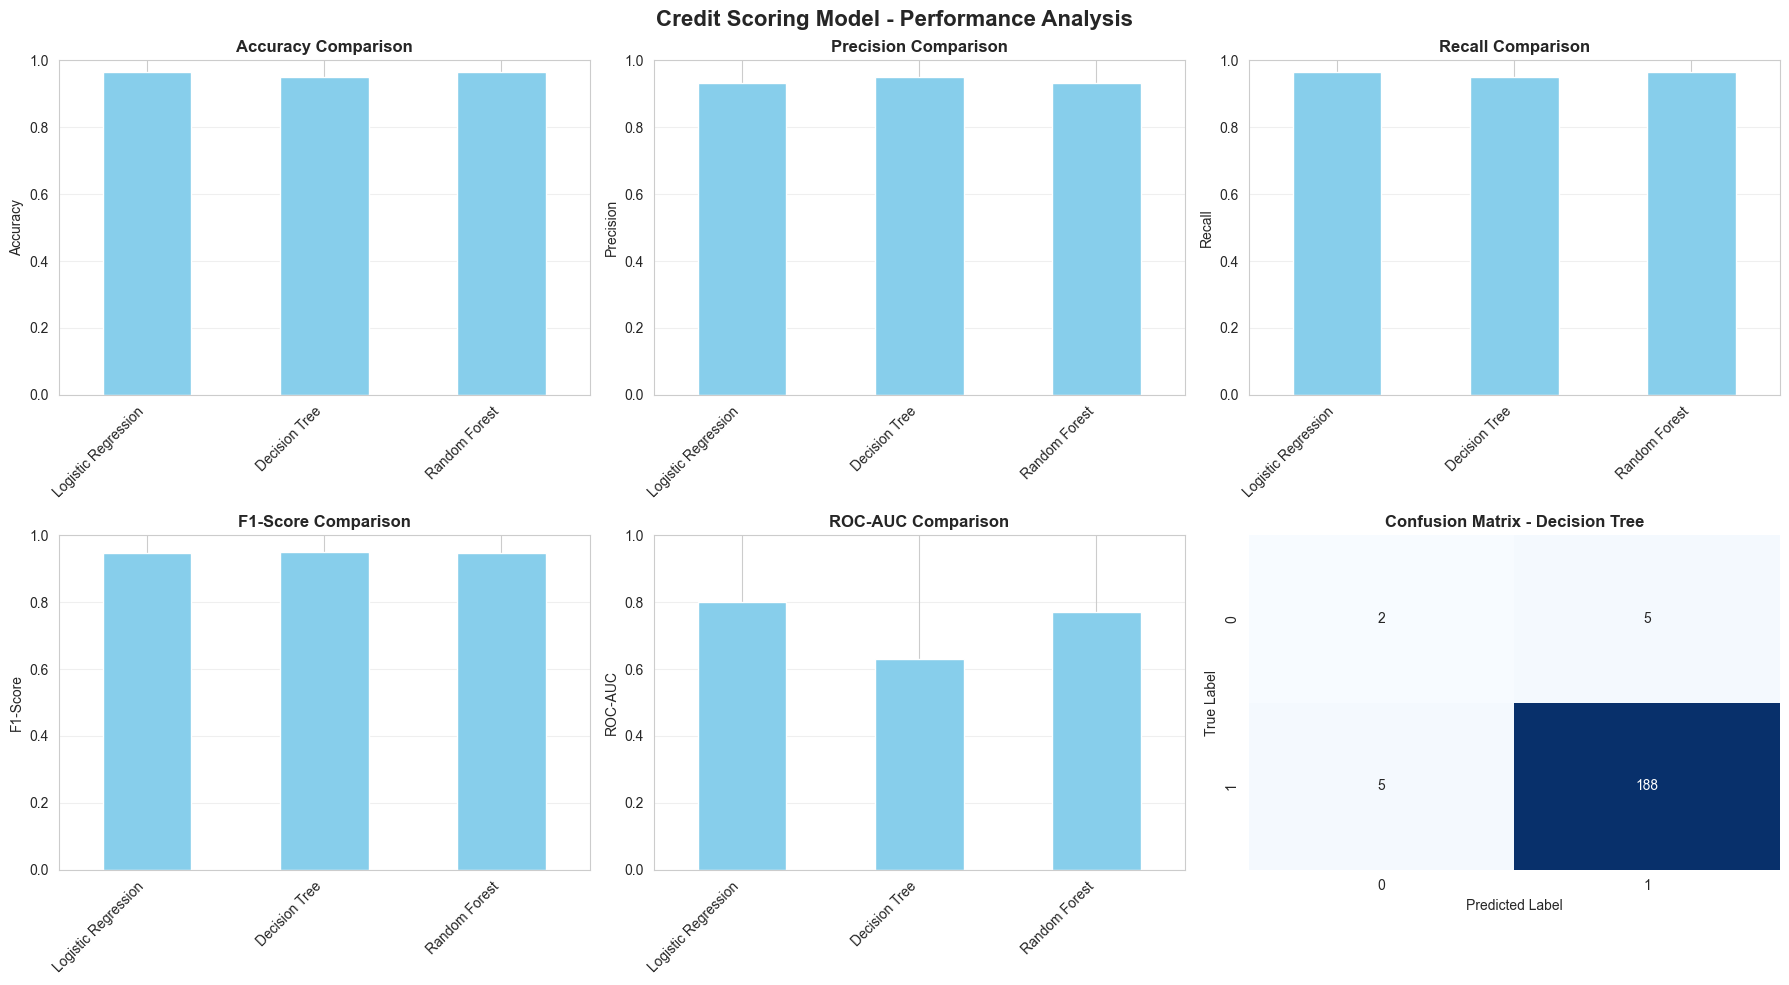

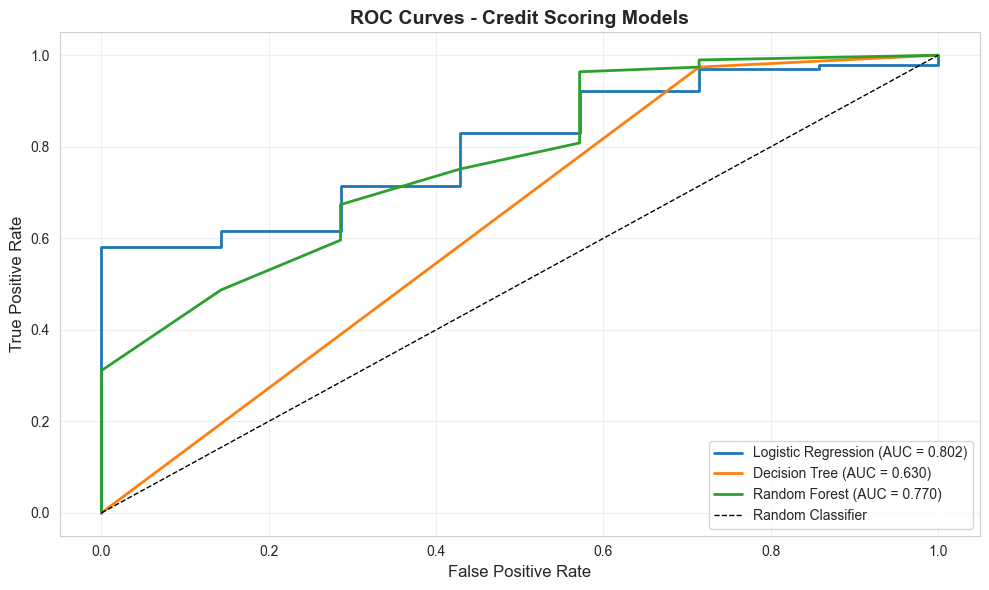

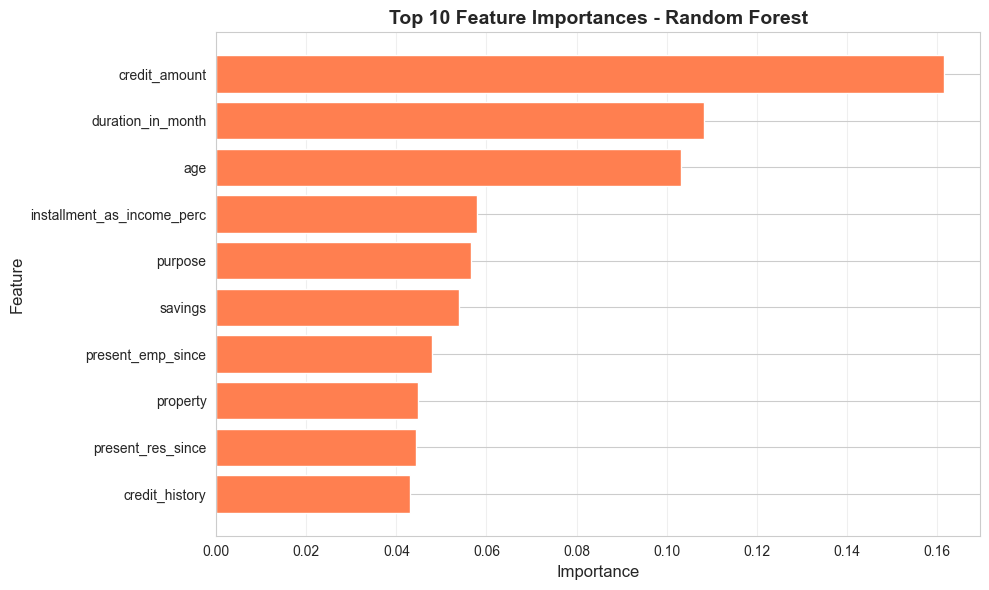

In [10]:
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# 1. Model Comparison Bar Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Credit Scoring Model - Performance Analysis', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, color='skyblue')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Confusion Matrix for best model
ax = axes[1, 2]
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['y_pred']
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 3. ROC Curve (for binary classification)
if len(np.unique(y)) == 2:
    plt.figure(figsize=(10, 6))
    for name in results.keys():
        y_pred_proba = results[name]['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = results[name]['roc_auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Credit Scoring Models', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 4. Feature Importance (for Random Forest)
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='coral')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top 10 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


DETAILED CLASSIFICATION REPORT

In [11]:
print("\n" + "="*80)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("="*80)
print(classification_report(y_test, results[best_model_name]['y_pred']))


DETAILED CLASSIFICATION REPORT - Decision Tree
              precision    recall  f1-score   support

           0       0.29      0.29      0.29         7
           1       0.97      0.97      0.97       193

    accuracy                           0.95       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.95      0.95      0.95       200



HYPERPARAMETER TUNING (OPTIONAL - FOR BEST MODEL)

In [12]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING (OPTIONAL)")
print("="*80)
print("\nTuning the best model for optimal performance...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1
    )
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    }
    grid_search = GridSearchCV(
        LogisticRegression(random_state=42, max_iter=1000),
        param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1
    )
else:  # Decision Tree
    param_grid = {
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1
    )

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
y_pred_tuned = grid_search.predict(X_test_scaled)
print(f"\nTuned Model Test F1-Score: {f1_score(y_test, y_pred_tuned, average='weighted'):.4f}")

print("\n" + "="*80)
print("MODEL TRAINING COMPLETE!")
print("="*80)
print("\n✅ All models trained and evaluated successfully")
print(f"✅ Best performing model: {best_model_name}")
print(f"✅ Best F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"✅ Best ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")


HYPERPARAMETER TUNING (OPTIONAL)

Tuning the best model for optimal performance...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Cross-Validation Score: 0.9378

Tuned Model Test F1-Score: 0.9500

MODEL TRAINING COMPLETE!

✅ All models trained and evaluated successfully
✅ Best performing model: Decision Tree
✅ Best F1-Score: 0.9500
✅ Best ROC-AUC: 0.6299
